# Hexapod Inverse Kinematics: A Step-by-Step Tutorial
## Usage
To get started with the Jupyter Notebook, follow these steps:

Prerequisites
It is recommended to use Anaconda or Miniconda to manage your Python environment and dependencies.

Download and install Anaconda or Miniconda, following the instructions for your operating system.
Create a new conda environment for this project:
```bash
conda create -n hexapod_tutorials python=3.8

```
Activate the new environment:
```bash
conda activate hexapod_tutorials
```
## Clone the repository and install dependencies
Clone the GitHub repository:
```bash
git clone https://github.com/robert-s-workshop/hexapod_tutorials
```
Navigate to the repository folder:
```bash
cd HexapodRoboticsTutorials
```
Install the required Python packages:
```bash
conda install jupyter numpy matplotlib
```
Launch Jupyter Notebook
Start Jupyter Notebook by running:
```bash
jupyter notebook
```
Your default web browser should open a new window or tab with the Jupyter Notebook interface. If not, you can manually open the link provided in the terminal.

Click on the Inverse_Kinematics_Notebook.ipynb file to open the notebook.

Now, you can interact with the notebook, execute the code cells, and follow along with the tutorial. Remember to save your progress as you go.



## Tutorial
In the inverseKinematics function, various trigonometric rules have been used to calculate the joint angles (theta1, theta2, and theta3) required to reach a target position. The main trigonometric functions used are arctangent (atan), arcsine (asin), and arccosine (acos). Along with these, some basic trigonometric identities and rules, such as the Pythagorean theorem and the cosine rule, have been employed to derive the required angles.

theta1 is calculated using arctangent, which gives the angle of a right-angled triangle with legs x and y. It represents the rotation around the base joint (Z-axis).

Intermediate values like Xa, Ya, Xb, Yb, P, G, and H are calculated using basic trigonometric functions like cosine and sine, and the Pythagorean theorem. These values help to create right-angled triangles for further calculations.

phi3 is calculated using arcsine, which gives the angle of a right-angled triangle with legs G and H.
phi2 and phi1 are calculated using the cosine rule. The cosine rule is applied to find the angles of a triangle when the lengths of all three sides are known. In this case, the sides are represented by the leg segments (COXA, FEMUR, TIBIA) and the calculated length H.

theta2 and theta3 are calculated based on the derived values of phi1, phi2, and phi3, as well as the sign of z. theta2 represents the angle at the coxa-femur joint, while theta3 represents the angle at the femur-tibia joint.
After calculating the joint angles, the function updates the joint angles of the SpiderLeg object and calls forwardKinematics() to update the joint positions accordingly.

In [1]:
from math import degrees, radians, cos, sin, sqrt, acos, atan,asin
import numpy as np

class SpiderLeg:
    def __init__(self, name, COXA, FEMUR, TIBIA):
        self.name = name
        self.COXA = COXA
        self.FEMUR = FEMUR
        self.TIBIA = TIBIA
        self.theta1 = 0.
        self.theta2 = 0.
        self.theta3 = 0.

        # Forward kinematics calculates the target position (x, y, z) based on the joint angles
        self.joints = self.forwardKinematics()

    def setAngles(self, angles):
        """
        Set the joint angles for the leg.
        
        Args:
            angles (list): A list of three angles in degrees, corresponding to theta1, theta2, and theta3.
            
        Returns:
            list: The updated joint angles.
        """
        angles = self.normalizeAngles(angles)
        self.theta1, self.theta2, self.theta3 = angles
        return self.getAngles()

    def getAngles(self):
        """
        Get the current joint angles.
        
        Returns:
            list: A list containing the current joint angles (theta1, theta2, theta3) in degrees.
        """
        return [self.theta1, self.theta2, self.theta3]

    def normalizeAngles(self, angles):
        """
        Normalize joint angles to be in the range [-180, 180] degrees.
        
        Args:
            angles (list): A list of joint angles in degrees.
            
        Returns:
            list: A list of normalized joint angles in degrees.
        """
        for idx, ang in enumerate(angles):
            sign = 1
            if ang < 0:
                sign = -1
            angles[idx] = sign * (abs(ang) % 360)
            if abs(ang) > 180:
                angles[idx] = ang - (360 * sign)
        return angles

    def getTarget(self):
        """
        Get the target position of the leg tip.
        
        Returns:
            list: A list containing the x, y, and z coordinates of the leg tip.
        """
        return self.joints[3]

        # Calculate the joint angles required to reach a target position using inverse kinematics
    def inverseKinematics(self, target=None):
        if target is None:
            target = self.joints[3]
        x, y, z = target[0], target[1], target[2]

        # Calculate theta1 using arctangent (tan^-1) based on x and y coordinates
        # arctan(y/x) gives the angle of a right-angled triangle with legs x and y
        theta1 = atan(y / x)

        # Calculate intermediate values for theta2 and theta3
        # Here, we apply trigonometric rules to find the lengths of the sides of the triangles
        # We use the cosine and sine functions to find the lengths Xa and Ya
        Xa = self.COXA * cos((theta1))
        Ya = self.COXA * sin((theta1))

        Xb = x - Xa
        Yb = y - Ya

        # Divide Xb by cos(theta1) to find P (projection of Xb on the x-axis)
        P = Xb / cos(theta1)

        # Calculate the absolute value of z, which will be used in the calculation of H
        G = abs(z)

        # Use Pythagorean theorem to find the length H (the hypotenuse of a right-angled triangle with legs P and G)
        H = sqrt(P ** 2 + G ** 2)

        # Calculate the angle phi3 using arcsine (sin^-1) based on G and H
        # arcsin(G/H) gives the angle of a right-angled triangle with legs G and H
        phi3 = asin(G / H)

        # Apply the cosine rule to find the angle phi2
        # Cosine rule: (c^2 = a^2 + b^2 - 2ab * cos(C))
        # We rearrange the formula to find the cosine of angle C:
        # cos(C) = (a^2 + b^2 - c^2) / (2ab)
        # In our case, a = self.TIBIA, b = H, c = self.FEMUR
        phi2Acos = ((self.TIBIA ** 2) + (H ** 2) - (self.FEMUR ** 2)) / (2 * self.TIBIA * H)
        phi2 = acos(phi2Acos)

        # Apply the cosine rule again to find the angle phi1
        # In this case, a = self.FEMUR, b = H, c = self.TIBIA
        phi1 = acos((self.FEMUR ** 2 + H ** 2 - self.TIBIA ** 2) / (2 * self.FEMUR * H))

        # Calculate theta2 and theta3 based on phi values and the sign of z
        # If z is positive, theta2 = phi1 + phi3; otherwise, theta2 = phi1 - phi3
        if z > 0:
            theta2 = phi1 + phi3
        else:
            theta2 = phi1 - phi3

        # Calculate theta3 as the sum of phi1 and phi2
        theta3 = phi1 + phi2

        # Update joint angles and forward kinematics with the new angles
        ang = [degrees(theta1), degrees(theta2), degrees(theta3)]
        self.setAngles(ang)
        self.forwardKinematics()
        return ang


    # Calculate the joint positions (x, y, z) based on the given joint angles using forward kinematics
    def forwardKinematics(self, angles=None):
        if angles is None:
            angles = [radians(self.theta1), radians(self.theta2), radians(self.theta3)]
        theta1, theta2, theta3 = angles

        # Calculate the positions of each joint based on the given angles
        Xa = self.COXA * cos((theta1))
        Ya = self.COXA * sin((theta1))
        G2 = sin(theta2) * self.FEMUR
        P1 = cos(theta2) * self.FEMUR
        Xc = cos(theta1) * P1
        Yc = sin(theta1) * P1

        # Calculate the position of the tip of the leg (end effector)
        H = sqrt(self.TIBIA ** 2 + self.FEMUR ** 2 - (2 * self.TIBIA * self.FEMUR * cos(radians(180) - theta3)))
        phi1 = acos((self.FEMUR ** 2 + H ** 2 - self.TIBIA ** 2) / (2 * self.FEMUR * H))
        phi2 = radians(180) - (radians(180) - theta3) - phi1
        phi3 = (phi1 - theta2)
        Pp = cos(phi3) * H
        P2 = Pp - P1
        Yb = sin(theta1) * Pp
        Xb = cos(theta1) * Pp
        G1 = sin(phi3) * H
        G1 = -G1

        # Store the joint positions in a list
        jointLocation = [
            [0, 0, 0],  # start joint
            [Xa, Ya, 0],  # coxa-femur joint
            [Xa + Xc, Ya + Yc, G2],  # femur-tibia joint
            [Xa + Xb, Ya + Yb, G1]  # tip of the leg
        ]

        self.joints = jointLocation
        return jointLocation


In [2]:
# Initialize a spider leg with given name and segment lengths
leg = SpiderLeg("Leg1", COXA=50, FEMUR=100, TIBIA=100)

# Set the joint angles (in degrees) for the leg
leg.setAngles([30, 45, 60])

# Get the current joint angles
currentAngles = leg.getAngles()

# Get the current target position (x, y, z) of the leg tip
currentTarget = leg.getTarget()
#Define the new tar4get
newTarget = [70, 70, -10]
# Calculate the joint angles required to reach a new target position using inverse kinematics
new_angles = leg.inverseKinematics(target=newTarget)

# Calculate the joint positions based on the joint angles using forward kinematics
# We do this to confirm that calculated angles are the ones required to reach the new target
joint_positions = leg.forwardKinematics()

# Print results
print("Current Joint Angles:", currentAngles)
print("Current Target Position:", currentTarget)
print("New Joint Angles:", new_angles)
print("New Joint Positions:", joint_positions)
print("Desired Target",newTarget,"Forward kinematics test", joint_positions[3])
print("Values in above arrays should be very close to each other")

Current Joint Angles: [30, 45, 60]
Current Target Position: [250.0, 0.0, -0.0]
New Joint Angles: [45.0, 63.98521570723465, 151.04198706516658]
New Joint Positions: [[0, 0, 0], [35.35533905932738, 35.35533905932737, 0], [66.36925830124655, 66.36925830124653, 89.86809014612157], [70.00000000000001, 70.0, -10.000000000000004]]
Desired Target [70, 70, -10] Forward kinematics test [70.00000000000001, 70.0, -10.000000000000004]
Values in above arrays should be very close to each other


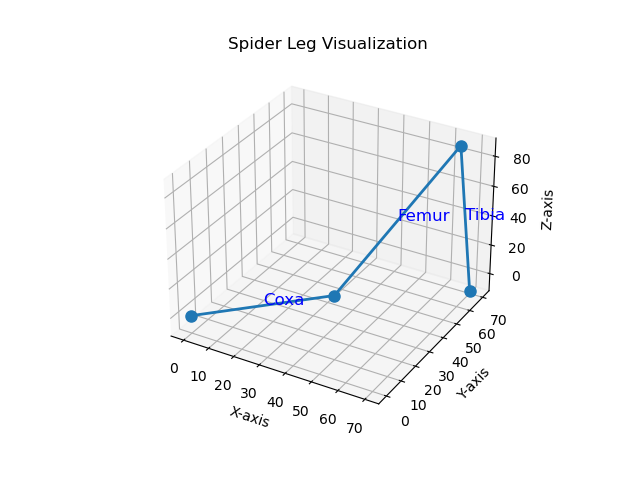

In [3]:
import matplotlib.pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

def plot_leg(joint_positions):
    # Create a new figure for the plot
    fig = plt.figure()
    
    # Add a 3D subplot to the figure, where 111 stands for 1x1 grid and the first subplot
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, and z coordinates of each joint from joint_positions
    x = [joint[0] for joint in joint_positions]
    y = [joint[1] for joint in joint_positions]
    z = [joint[2] for joint in joint_positions]

    # Plot the leg segments connecting the joints with markers at each joint
    ax.plot(x, y, z, "-o", linewidth=2, markersize=8)

    # Calculate the midpoints of each segment (Coxa, Femur, and Tibia)
    coxa_mid = [(joint_positions[0][i] + joint_positions[1][i])/2 for i in range(3)]
    femur_mid = [(joint_positions[1][i] + joint_positions[2][i])/2 for i in range(3)]
    tibia_mid = [(joint_positions[2][i] + joint_positions[3][i])/2 for i in range(3)]

    # Add labels for each segment at their respective midpoints
    ax.text(coxa_mid[0], coxa_mid[1], coxa_mid[2], 'Coxa', fontsize=12, color='blue')
    ax.text(femur_mid[0], femur_mid[1], femur_mid[2], 'Femur', fontsize=12, color='blue')
    ax.text(tibia_mid[0], tibia_mid[1], tibia_mid[2], 'Tibia', fontsize=12, color='blue')

    # Set labels for the x, y, and z axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # Set the title for the plot
    ax.set_title('Spider Leg Visualization')

    # Display the plot
    plt.show()

# Call the plot_leg function with the joint_positions
plot_leg(joint_positions)